In [172]:
import pandas as pd
import numpy as np
import const
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [173]:
hs92_df = pd.read_csv('./data/hs92-2021.csv')

In [174]:
def clean_hs_code(hs_code: int) -> str:
    return '0' * (6 - len(str(hs_code))) + str(hs_code)

def extract_hs_code(hs_code: str, subsection: int) -> int:
    assert len(hs_code) == 6
    if subsection == 2:
        return int(hs_code[:2])
    elif subsection == 4:
        return int(hs_code[:4])
    elif subsection == 6:
        return int(hs_code[:6])
    else:
        raise RuntimeError()
        
def convert_hs4code_to_int(hs4_code: str) -> int:
    return const.hs4code_to_int[hs4_code]

In [175]:
# Drop irrelevant labels
hs92_df.drop(
    columns=['year', 'exporter_name', 'importer_id', 'importer_name', 'product_name', 'hs_revision', 'quantity', 'unit_abbrevation', 'unit_name'],
    inplace=True
)

# Prepare the column names
hs92_df['hs_code'] = hs92_df['hs_code'].apply(clean_hs_code)
code = 4
hs_cat = f"hs{code}"
hs92_df[hs_cat] = hs92_df['hs_code'].apply(extract_hs_code, args=(code,))
hs92_df.drop(columns='hs_code', inplace=True)
hs92_df.to_csv('./data/clean.csv', index=False)
hs92_df.head()

,exporter_id,value,hs4
0,ago,91407.0,303
1,ago,3013157.0,303
2,ago,349993.0,7214
3,ago,577.0,8516
4,ago,26006.0,8705


In [176]:
# Aggregate the values for each country and HS code
aggregated_data = hs92_df.groupby(['exporter_id', hs_cat]).sum().reset_index()

# Pivot the data so each HS code becomes a column
pivot_data = aggregated_data.pivot(index='exporter_id', columns=hs_cat, values='value').fillna(0)

# Create total exports column
pivot_data['export_total'] = pivot_data.sum(axis=1)

# Convert to percentages
normalized_df = pivot_data.div(pivot_data['export_total'], axis=0)
normalized_df *= 100
normalized_df = normalized_df.round(2)
normalized_df['export_total'] = pivot_data['export_total']
normalized_df

hs4,101,102,103,104,105,106,201,202,203,204,...,9616,9617,9618,9701,9702,9703,9704,9705,9706,export_total
exporter_id,,,,,,,,,,,,,,,,,,,,,
\N,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.00,0.00,4.782668e+11
abw,0.01,0.00,0.0,0.00,0.03,0.03,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.17,0.0,0.00,0.0,0.00,0.00,1.903756e+08
afg,0.00,0.00,0.0,0.01,0.00,0.01,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.01,0.16,1.884859e+09
ago,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,3.495860e+10
aia,0.00,0.00,0.0,0.00,0.00,0.01,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.08,0.0,0.00,0.0,0.03,0.00,3.046792e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wsm,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.01,0.01,0.13,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.02,0.02,5.808433e+07
yem,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.01,1.974097e+09
zaf,0.00,0.02,0.0,0.01,0.01,0.01,0.06,0.05,0.02,0.01,...,0.0,0.0,0.0,0.03,0.0,0.01,0.0,0.01,0.00,1.434647e+11


In [217]:
# Trillion dollar countries
trillion_rows = normalized_df[normalized_df['export_total'] >= 1e12]
trillion_rows

hs4,101,102,103,104,105,106,201,202,203,204,...,9616,9617,9618,9701,9702,9703,9704,9705,9706,export_total
exporter_id,,,,,,,,,,,,,,,,,,,,,
chn,0.02,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.0,...,0.03,0.10,0.01,0.05,0.00,0.00,0.0,0.00,0.01,3.337971e+12
deu,0.02,0.02,0.01,0.0,0.04,0.00,0.08,0.01,0.25,0.0,...,0.01,0.01,0.00,0.05,0.00,0.02,0.0,0.01,0.00,1.563447e+12
usa,0.02,0.03,0.00,0.0,0.02,0.01,0.28,0.27,0.36,0.0,...,0.00,0.01,0.00,0.30,0.01,0.06,0.0,0.02,0.02,1.628145e+12


In [219]:
# Random countries defined uniquely by specific categories
for col in normalized_df.columns:
    # Create a mask for values greater than 50%
    mask = (normalized_df[col] >= 10) & (normalized_df[col] <= 100)
    
    # Check if exactly one value in the column is greater than 50%
    if mask.sum() == 1:
        # Find the index of the row with the value greater than 50%
        index = normalized_df.index[mask].tolist()[0]  # Get the single index as an integer
        print(f"Column '{col}': {index}")

Column '104': som
Column '202': ury
Column '305': iot
Column '402': nzl
Column '603': ken
Column '709': ton
Column '806': afg
Column '905': mdg
Column '907': com
Column '908': grd
Column '1005': arg
Column '1209': nfk
Column '1507': npl
Column '1509': syr
Column '1513': wsm
Column '1905': pcn
Column '2008': ton
Column '2201': fji
Column '2204': blm
Column '2208': brb
Column '2301': asm
Column '2304': arg
Column '2505': msr
Column '2602': gab
Column '2604': ncl
Column '2606': gin
Column '2614': sle
Column '2814': tto
Column '2818': jam
Column '2827': dji
Column '2844': nam
Column '2902': brn
Column '2933': irl
Column '3103': cxr
Column '3104': jor
Column '3301': com
Column '3302': swz
Column '3815': mkd
Column '3823': swz
Column '3901': irn
Column '4015': blm
Column '4407': gmb
Column '4703': ury
Column '5201': ben
Column '5205': uzb
Column '6104': lso
Column '6204': bgd
Column '6302': pak
Column '6802': pse
Column '7020': tkl
Column '7101': pyf
Column '7106': tkl
Column '7110': zaf
Col

In [182]:
drop_data = normalized_df.copy()
drop_data.drop(columns='export_total')
stopping_depth = 65

for col in drop_data.columns:
    drop_data.drop(columns=col, inplace=True)
    print(col)
    print(drop_data.shape)
    X = drop_data.iloc[:, 0:-1].to_numpy()
    y = drop_data.index
    accuracies = []

    depths = range(stopping_depth, 0, -1)
    for depth in depths:
        clf = DecisionTreeClassifier(random_state=0, max_depth=depth).fit(X, y)
        train_predictions = clf.predict(X)
        accuracy = accuracy_score(y, train_predictions)
        if accuracy == 1.0:
            accuracies.append(accuracy)
            print(f"Max Depth: {depth}, Accuracy: {accuracy}")
        else:
            stopping_depth = depth
            print(f"Finished {accuracy} at depth: {depth}")
            break

    print(f"Stopping depth: {stopping_depth}")

101
(226, 1217)
Max Depth: 65, Accuracy: 1.0
Max Depth: 64, Accuracy: 1.0
Max Depth: 63, Accuracy: 1.0
Max Depth: 62, Accuracy: 1.0
Max Depth: 61, Accuracy: 1.0
Max Depth: 60, Accuracy: 1.0
Max Depth: 59, Accuracy: 1.0
Max Depth: 58, Accuracy: 1.0
Max Depth: 57, Accuracy: 1.0
Max Depth: 56, Accuracy: 1.0
Max Depth: 55, Accuracy: 1.0
Max Depth: 54, Accuracy: 1.0
Max Depth: 53, Accuracy: 1.0
Max Depth: 52, Accuracy: 1.0
Max Depth: 51, Accuracy: 1.0
Max Depth: 50, Accuracy: 1.0
Max Depth: 49, Accuracy: 1.0
Max Depth: 48, Accuracy: 1.0
Max Depth: 47, Accuracy: 1.0
Max Depth: 46, Accuracy: 1.0
Max Depth: 45, Accuracy: 1.0
Max Depth: 44, Accuracy: 1.0
Max Depth: 43, Accuracy: 1.0
Max Depth: 42, Accuracy: 1.0
Max Depth: 41, Accuracy: 1.0
Max Depth: 40, Accuracy: 1.0
Max Depth: 39, Accuracy: 1.0
Max Depth: 38, Accuracy: 1.0
Max Depth: 37, Accuracy: 1.0
Max Depth: 36, Accuracy: 1.0
Max Depth: 35, Accuracy: 1.0
Max Depth: 34, Accuracy: 1.0
Max Depth: 33, Accuracy: 1.0
Max Depth: 32, Accuracy: 1.

Finished 0.911504424778761 at depth: 18
Stopping depth: 18
1008
(226, 1126)
Finished 0.9601769911504425 at depth: 18
Stopping depth: 18
1101
(226, 1125)
Finished 0.7079646017699115 at depth: 18
Stopping depth: 18
1102
(226, 1124)
Finished 0.8451327433628318 at depth: 18
Stopping depth: 18
1103
(226, 1123)
Finished 0.8849557522123894 at depth: 18
Stopping depth: 18
1104
(226, 1122)
Finished 0.9646017699115044 at depth: 18
Stopping depth: 18
1105
(226, 1121)
Finished 0.9778761061946902 at depth: 18
Stopping depth: 18
1106
(226, 1120)
Finished 0.9203539823008849 at depth: 18
Stopping depth: 18
1107
(226, 1119)
Finished 0.8672566371681416 at depth: 18
Stopping depth: 18
1108
(226, 1118)
Finished 0.9911504424778761 at depth: 18
Stopping depth: 18
1109
(226, 1117)
Finished 0.9203539823008849 at depth: 18
Stopping depth: 18
1201
(226, 1116)
Finished 0.8584070796460177 at depth: 18
Stopping depth: 18
1202
(226, 1115)
Finished 0.9734513274336283 at depth: 18
Stopping depth: 18
1203
(226, 1114)


Finished 0.8407079646017699 at depth: 16
Stopping depth: 16
2501
(226, 1020)
Finished 0.9292035398230089 at depth: 16
Stopping depth: 16
2502
(226, 1019)
Finished 0.8097345132743363 at depth: 16
Stopping depth: 16
2503
(226, 1018)
Finished 0.7964601769911505 at depth: 16
Stopping depth: 16
2504
(226, 1017)
Finished 0.7654867256637168 at depth: 16
Stopping depth: 16
2505
(226, 1016)
Finished 0.6548672566371682 at depth: 16
Stopping depth: 16
2506
(226, 1015)
Finished 0.7035398230088495 at depth: 16
Stopping depth: 16
2507
(226, 1014)
Finished 0.915929203539823 at depth: 16
Stopping depth: 16
2508
(226, 1013)
Finished 0.6902654867256637 at depth: 16
Stopping depth: 16
2509
(226, 1012)
Finished 0.7168141592920354 at depth: 16
Stopping depth: 16
2510
(226, 1011)
Finished 0.8407079646017699 at depth: 16
Stopping depth: 16
2511
(226, 1010)
Finished 0.8008849557522124 at depth: 16
Stopping depth: 16
2512
(226, 1009)
Finished 0.8805309734513275 at depth: 16
Stopping depth: 16
2513
(226, 1008)


Finished 0.827433628318584 at depth: 16
Stopping depth: 16
2844
(226, 912)
Finished 0.8893805309734514 at depth: 16
Stopping depth: 16
2845
(226, 911)
Finished 0.7964601769911505 at depth: 16
Stopping depth: 16
2846
(226, 910)
Finished 0.6858407079646017 at depth: 16
Stopping depth: 16
2847
(226, 909)
Finished 0.8539823008849557 at depth: 16
Stopping depth: 16
2848
(226, 908)
Finished 0.7699115044247787 at depth: 16
Stopping depth: 16
2849
(226, 907)
Finished 0.8716814159292036 at depth: 16
Stopping depth: 16
2850
(226, 906)
Finished 0.915929203539823 at depth: 16
Stopping depth: 16
2851
(226, 905)
Finished 0.7743362831858407 at depth: 16
Stopping depth: 16
2901
(226, 904)
Finished 0.8185840707964602 at depth: 16
Stopping depth: 16
2902
(226, 903)
Finished 0.7522123893805309 at depth: 16
Stopping depth: 16
2903
(226, 902)
Finished 0.8805309734513275 at depth: 16
Stopping depth: 16
2904
(226, 901)
Finished 0.8805309734513275 at depth: 16
Stopping depth: 16
2905
(226, 900)
Finished 0.924

Finished 0.7212389380530974 at depth: 16
Stopping depth: 16
3707
(226, 803)
Finished 0.8185840707964602 at depth: 16
Stopping depth: 16
3801
(226, 802)
Finished 0.9336283185840708 at depth: 16
Stopping depth: 16
3802
(226, 801)
Finished 0.9026548672566371 at depth: 16
Stopping depth: 16
3803
(226, 800)
Finished 0.7964601769911505 at depth: 16
Stopping depth: 16
3804
(226, 799)
Finished 0.6637168141592921 at depth: 16
Stopping depth: 16
3805
(226, 798)
Finished 0.9601769911504425 at depth: 16
Stopping depth: 16
3806
(226, 797)
Finished 0.827433628318584 at depth: 16
Stopping depth: 16
3807
(226, 796)
Finished 0.9292035398230089 at depth: 16
Stopping depth: 16
3808
(226, 795)
Finished 0.9513274336283186 at depth: 16
Stopping depth: 16
3809
(226, 794)
Finished 0.8716814159292036 at depth: 16
Stopping depth: 16
3810
(226, 793)
Finished 0.9203539823008849 at depth: 16
Stopping depth: 16
3811
(226, 792)
Finished 0.7566371681415929 at depth: 16
Stopping depth: 16
3812
(226, 791)
Finished 0.75

Finished 0.8982300884955752 at depth: 15
Stopping depth: 15
4503
(226, 693)
Finished 0.8185840707964602 at depth: 15
Stopping depth: 15
4504
(226, 692)
Finished 0.8584070796460177 at depth: 15
Stopping depth: 15
4601
(226, 691)
Finished 0.8053097345132744 at depth: 15
Stopping depth: 15
4602
(226, 690)
Finished 0.6548672566371682 at depth: 15
Stopping depth: 15
4701
(226, 689)
Finished 0.9336283185840708 at depth: 15
Stopping depth: 15
4702
(226, 688)
Finished 0.8761061946902655 at depth: 15
Stopping depth: 15
4703
(226, 687)
Finished 0.7876106194690266 at depth: 15
Stopping depth: 15
4704
(226, 686)
Finished 0.7787610619469026 at depth: 15
Stopping depth: 15
4705
(226, 685)
Finished 0.7256637168141593 at depth: 15
Stopping depth: 15
4706
(226, 684)
Finished 0.9513274336283186 at depth: 15
Stopping depth: 15
4707
(226, 683)
Finished 0.8141592920353983 at depth: 15
Stopping depth: 15
4801
(226, 682)
Finished 0.827433628318584 at depth: 15
Stopping depth: 15
4802
(226, 681)
Finished 0.67

Finished 0.7787610619469026 at depth: 15
Stopping depth: 15
5515
(226, 585)
Finished 0.8628318584070797 at depth: 15
Stopping depth: 15
5516
(226, 584)
Finished 0.8539823008849557 at depth: 15
Stopping depth: 15
5601
(226, 583)
Finished 0.8672566371681416 at depth: 15
Stopping depth: 15
5602
(226, 582)
Finished 0.7566371681415929 at depth: 15
Stopping depth: 15
5603
(226, 581)
Finished 0.9247787610619469 at depth: 15
Stopping depth: 15
5604
(226, 580)
Finished 0.8407079646017699 at depth: 15
Stopping depth: 15
5605
(226, 579)
Finished 0.9690265486725663 at depth: 15
Stopping depth: 15
5606
(226, 578)
Finished 0.8761061946902655 at depth: 15
Stopping depth: 15
5607
(226, 577)
Finished 0.9424778761061947 at depth: 15
Stopping depth: 15
5608
(226, 576)
Finished 0.7522123893805309 at depth: 15
Stopping depth: 15
5609
(226, 575)
Finished 0.7743362831858407 at depth: 15
Stopping depth: 15
5701
(226, 574)
Finished 0.9734513274336283 at depth: 15
Stopping depth: 15
5702
(226, 573)
Finished 0.7

Finished 0.8495575221238938 at depth: 15
Stopping depth: 15
6808
(226, 475)
Finished 0.8362831858407079 at depth: 15
Stopping depth: 15
6809
(226, 474)
Finished 0.9778761061946902 at depth: 15
Stopping depth: 15
6810
(226, 473)
Finished 0.6150442477876106 at depth: 15
Stopping depth: 15
6811
(226, 472)
Finished 0.6194690265486725 at depth: 15
Stopping depth: 15
6812
(226, 471)
Finished 0.8716814159292036 at depth: 15
Stopping depth: 15
6813
(226, 470)
Finished 0.7256637168141593 at depth: 15
Stopping depth: 15
6814
(226, 469)
Finished 0.8805309734513275 at depth: 15
Stopping depth: 15
6815
(226, 468)
Finished 0.7168141592920354 at depth: 15
Stopping depth: 15
6901
(226, 467)
Finished 0.8893805309734514 at depth: 15
Stopping depth: 15
6902
(226, 466)
Finished 0.8362831858407079 at depth: 15
Stopping depth: 15
6903
(226, 465)
Finished 0.7876106194690266 at depth: 15
Stopping depth: 15
6904
(226, 464)
Finished 0.7964601769911505 at depth: 15
Stopping depth: 15
6905
(226, 463)
Finished 0.9

Finished 0.7787610619469026 at depth: 14
Stopping depth: 14
7325
(226, 363)
Finished 0.6415929203539823 at depth: 14
Stopping depth: 14
7326
(226, 362)
Finished 0.9026548672566371 at depth: 14
Stopping depth: 14
7401
(226, 361)
Finished 0.8097345132743363 at depth: 14
Stopping depth: 14
7402
(226, 360)
Finished 0.8407079646017699 at depth: 14
Stopping depth: 14
7403
(226, 359)
Finished 0.8141592920353983 at depth: 14
Stopping depth: 14
7404
(226, 358)
Finished 0.9203539823008849 at depth: 14
Stopping depth: 14
7405
(226, 357)
Finished 0.7964601769911505 at depth: 14
Stopping depth: 14
7406
(226, 356)
Finished 0.7477876106194691 at depth: 14
Stopping depth: 14
7407
(226, 355)
Finished 0.8362831858407079 at depth: 14
Stopping depth: 14
7408
(226, 354)
Finished 0.7876106194690266 at depth: 14
Stopping depth: 14
7409
(226, 353)
Finished 0.7300884955752213 at depth: 14
Stopping depth: 14
7410
(226, 352)
Finished 0.8230088495575221 at depth: 14
Stopping depth: 14
7411
(226, 351)
Finished 0.6

Finished 0.8495575221238938 at depth: 14
Stopping depth: 14
8414
(226, 255)
Finished 0.7389380530973452 at depth: 14
Stopping depth: 14
8415
(226, 254)
Finished 0.911504424778761 at depth: 14
Stopping depth: 14
8416
(226, 253)
Finished 0.8185840707964602 at depth: 14
Stopping depth: 14
8417
(226, 252)
Finished 0.8362831858407079 at depth: 14
Stopping depth: 14
8418
(226, 251)
Finished 0.8495575221238938 at depth: 14
Stopping depth: 14
8419
(226, 250)
Finished 0.8451327433628318 at depth: 14
Stopping depth: 14
8420
(226, 249)
Finished 0.7079646017699115 at depth: 14
Stopping depth: 14
8421
(226, 248)
Finished 0.831858407079646 at depth: 14
Stopping depth: 14
8422
(226, 247)
Finished 0.7654867256637168 at depth: 14
Stopping depth: 14
8423
(226, 246)
Finished 0.6592920353982301 at depth: 14
Stopping depth: 14
8424
(226, 245)
Finished 0.8849557522123894 at depth: 14
Stopping depth: 14
8425
(226, 244)
Finished 0.8805309734513275 at depth: 14
Stopping depth: 14
8426
(226, 243)
Finished 0.685

Finished 0.7123893805309734 at depth: 14
Stopping depth: 14
8540
(226, 144)
Finished 0.8053097345132744 at depth: 14
Stopping depth: 14
8541
(226, 143)
Finished 0.6592920353982301 at depth: 14
Stopping depth: 14
8542
(226, 142)
Finished 0.8716814159292036 at depth: 14
Stopping depth: 14
8543
(226, 141)
Finished 0.8141592920353983 at depth: 14
Stopping depth: 14
8544
(226, 140)
Finished 0.8185840707964602 at depth: 14
Stopping depth: 14
8545
(226, 139)
Finished 0.6150442477876106 at depth: 14
Stopping depth: 14
8546
(226, 138)
Finished 0.9557522123893806 at depth: 14
Stopping depth: 14
8547
(226, 137)
Finished 0.8672566371681416 at depth: 14
Stopping depth: 14
8548
(226, 136)
Finished 0.7610619469026548 at depth: 14
Stopping depth: 14
8601
(226, 135)
Finished 0.7787610619469026 at depth: 14
Stopping depth: 14
8602
(226, 134)
Finished 0.8008849557522124 at depth: 14
Stopping depth: 14
8603
(226, 133)
Finished 0.8451327433628318 at depth: 14
Stopping depth: 14
8604
(226, 132)
Finished 0.7

ValueError: Found array with 0 feature(s) (shape=(226, 0)) while a minimum of 1 is required by DecisionTreeClassifier.

hs4          7020  7101  7102  7103  7106   7108   7110  7112  7113  7118  \
exporter_id                                                                 
\N           0.02   0.0  0.01  0.00  0.22   0.17   0.10  0.09  0.07  0.00   
abw          0.00   0.0  0.02  0.09  0.00   0.00   0.00  0.11  1.08  0.00   
afg          0.00   0.0  0.00  0.61  0.01  22.23   0.00  0.00  0.01  0.00   
ago          0.00   0.0  7.92  0.00  0.00   0.04   0.00  0.00  0.00  0.00   
aia          0.00   0.0  0.00  0.01  0.00   0.00   0.00  0.07  0.02  0.00   
...           ...   ...   ...   ...   ...    ...    ...   ...   ...   ...   
wsm          0.00   0.0  0.00  0.00  0.00   0.00   0.00  0.18  0.00  0.08   
yem          0.00   0.0  0.00  0.02  0.00   3.68   0.00  0.36  0.00  0.00   
zaf          0.00   0.0  4.89  0.03  0.03  14.04  17.10  0.28  0.12  0.01   
zmb          0.00   0.0  0.01  2.09  0.00   6.08   0.00  0.40  0.02  0.00   
zwe          0.00   0.0  3.13  0.01  0.00  46.82   0.76  0.01  0.06  0.00   

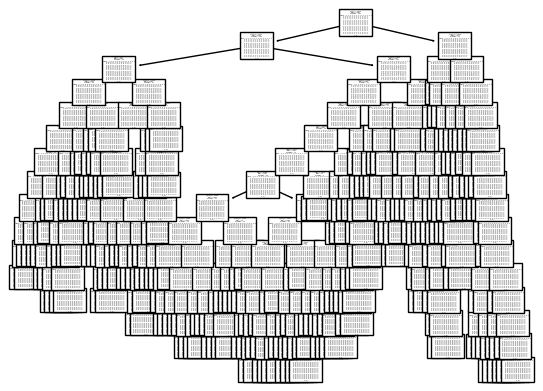

In [190]:
# norm_df = normalized_df.copy()
# col_index = norm_df.columns.get_loc(7019)
# norm_df = norm_df.iloc[:, col_index+1:]
print(norm_df)

X = norm_df.iloc[:, 0:-1].to_numpy()
y = norm_df.index

clf = DecisionTreeClassifier(random_state=0, max_depth=15).fit(X, y)
train_predictions = clf.predict(X)
accuracy = accuracy_score(y, train_predictions)
print(accuracy)

# Plotting
# plt.figure(figsize=(100, 100))
# plt.plot(depths, accuracies, marker='o')
# plt.title('Decision Tree Depth vs. Accuracy')
# plt.xlabel('Max Depth')
# plt.ylabel('Accuracy')
# plt.grid(True)
# plt.show()

plot_tree(clf)
plt.show()

In [189]:
cols_to_drop = []

# Iterate through each column in the DataFrame
for col in norm_df.columns:
    # Check if all elements in the column are less than 1
    if (norm_df[col] < 1).all():
        # If so, append the column name to the list
        cols_to_drop.append(col)

# Drop the identified columns from the DataFrame
norm_df = norm_df.drop(columns=cols_to_drop)

hs4,7020,7101,7102,7103,7106,7108,7110,7112,7113,7118,...,9403,9404,9405,9406,9503,9504,9507,9701,9705,export_total
exporter_id,,,,,,,,,,,,,,,,,,,,,
\N,0.02,0.0,0.01,0.00,0.22,0.17,0.10,0.09,0.07,0.00,...,0.35,0.06,0.07,0.01,0.09,0.04,0.01,0.01,0.00,4.782668e+11
abw,0.00,0.0,0.02,0.09,0.00,0.00,0.00,0.11,1.08,0.00,...,0.61,0.00,0.02,0.00,0.00,0.18,0.00,0.17,0.00,1.903756e+08
afg,0.00,0.0,0.00,0.61,0.01,22.23,0.00,0.00,0.01,0.00,...,0.01,0.00,0.01,0.08,0.00,0.00,0.00,0.00,0.01,1.884859e+09
ago,0.00,0.0,7.92,0.00,0.00,0.04,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,3.495860e+10
aia,0.00,0.0,0.00,0.01,0.00,0.00,0.00,0.07,0.02,0.00,...,0.12,0.00,0.00,0.00,0.02,0.35,0.00,0.08,0.03,3.046792e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wsm,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.08,...,0.28,0.06,0.01,0.00,0.18,0.00,0.00,0.00,0.02,5.808433e+07
yem,0.00,0.0,0.00,0.02,0.00,3.68,0.00,0.36,0.00,0.00,...,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.974097e+09
zaf,0.00,0.0,4.89,0.03,0.03,14.04,17.10,0.28,0.12,0.01,...,0.07,0.03,0.04,0.03,0.01,0.01,0.01,0.03,0.01,1.434647e+11
